# Data Science e Machine Learning na Prática - Introdução e Aplicações na Indústria de Processos

### Notebook 6 - Detecção de falhas no processo Tennessee Eastman usando PCA

por [Afrânio](http://afrjr.weebly.com) - [afraeq@gmail.com](mailto:afrjr3@gmail.com)

[Escola Piloto Prof. Giulio Massarani](http://www.escolapiloto.peq.coppe.ufrj.br/) - [Programa de Engenharia Química, COPPE, UFRJ](http://portal.peq.coppe.ufrj.br/) - 2019

Neste [notebook](http://jupyter.org/), o problema da detecção de falhas usando o método PCA é estudado no contexto do processo Tennessee Eastman.

Conceitos importantes a aprender:

* controle estatístico, monitoramento de processos e detecção de falhas;
* o processo Tennessee Eastman (*benchmark* muito usado na área de Análise de Processos);
* variância explicada cumulativa;
* SPE (*squared prediction error*).

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import scale
#from sklearn.decomposition import PCA

# dados
# https://github.com/camaramm/tennessee-eastman-profBraatz

### Métodos de treinamento e teste com PCA:

In [2]:
def treinar_PCA(X_treino, var_exp, lim_conf, ax=None):
    
    Sxx_treino = np.cov(scale(X_treino), rowvar=False)
    _, S, V = np.linalg.svd(Sxx_treino)

    pv = S/np.sum(S)
    pva = np.cumsum(S)/sum(S)
    n = np.where(pva>var_exp)[0][0]

    X_treino_proj = scale(X_treino).dot(V[:,:n])
    X_treino_pred = X_treino_proj.dot(V[:,:n].T)

    SPE_treino = np.sum((scale(X_treino)-X_treino_pred)**2,axis=1)
        
    iSPE = np.sort(SPE_treino[0:int(0.5*X_treino.shape[0])])
    limSPE = iSPE[int(lim_conf*int(0.5*X_treino.shape[0]))]  
    
    if ax is not None:
    
        ax.plot(X_treino.index,SPE_treino,label = 'SPE - treino')


        ax.axhline(limSPE,color='red',
                           ls = '--',
                           label='Limite de %.0f%% de confiança' %(lim_conf*100))

        ax.legend(fontsize=12);
    
    return V, n, SPE_treino, limSPE, S

In [3]:
def testar_PCA (X_teste, X_treino, V, n, limSPE, lim_conf, ax=None):

    X_teste = (X_teste - X_treino.mean())/X_treino.std()

    X_teste_proj = X_teste.values.dot(V[:,:n])
    X_teste_pred = X_teste_proj.dot(V[:,:n].T)

    SPE_teste = np.sum((X_teste.values-X_teste_pred)**2,axis=1)
    
    if ax is not None:
    
        ax.plot(X_teste.index,SPE_teste,label = 'SPE - treino')

        ax.axhline(limSPE,color='red',
                           ls = '--',
                           label='Limite de %.0f%% de confiança' %(lim_conf*100))

        ax.legend(fontsize=12);
        
    return SPE_teste

### Esquemático do processo

<img src="https://image.ibb.co/hEnuVz/esss.png" width="900" height="900"/>

### Leitura dos dados

Tags das variáveis:

In [4]:
tags1 = ['XMEAS('+str(ii)+')' for ii in range(1,42)]
tags2 = ['XMV('+str(ii)+')' for ii in range(1,12)]
tags = tags1 + tags2

Lendo dados de treino e de teste:

In [5]:
dados_treino = []
dados_teste = []

for arquivo in os.listdir('./TE_process'):
    if arquivo=='d00.dat':
        continue
    if arquivo.endswith('.dat'):
        if arquivo.endswith('_te.dat'):
            dados_teste.append(pd.read_csv('./TE_process/'+arquivo, delim_whitespace=True, names=tags))
        else:
            dados_treino.append(pd.read_csv('./TE_process/'+arquivo, delim_whitespace=True, names=tags))

Lendo dados de treino no período normal (arquivo original está com problemas e sua leitura precisou ser adaptada):

In [6]:
tmp1 = pd.read_csv('TE_process/d00.dat',sep='\t',names='0')
tmp2 = pd.DataFrame([tmp1.T.iloc[0,i].strip() for i in range(tmp1.shape[0])])
tmp3 = pd.DataFrame()

for ii in range(52):
    tmp3[tags[ii]] = [float(s) for s in tmp2[0][ii].split('  ')]
    
dados_treino.insert(0,tmp3)

Convertendo os índices para tempo (em horas):

In [7]:
for i in range(len(dados_teste)):
    dados_teste[i].index = (dados_teste[i].index+1)*0.05
    dados_treino[i].index = (dados_treino[i].index+1)*0.05

Reproduzindo a figura 10.1 do livro [Steven Ding - Data-driven Design of Fault Diagnosis and Fault-tolerant Control Systems - Springer](https://www.springer.com/la/book/9781447164098) (exemplo de uma falha óbvia):

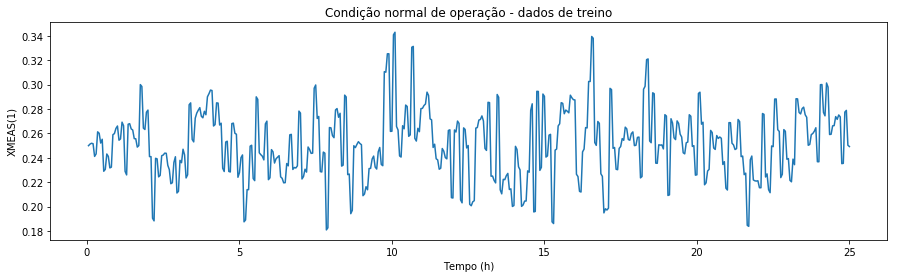

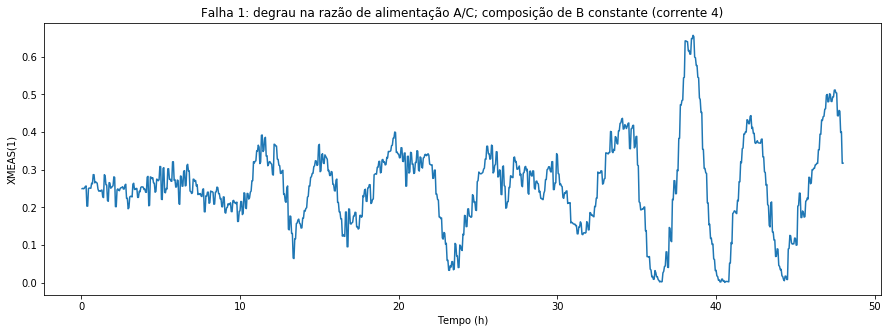

In [8]:
fig,ax = plt.subplots(figsize=(15,4))
dados_treino[0].iloc[:,0].plot(ax=ax)
ax.set_xlabel('Tempo (h)')
ax.set_ylabel(tags[0])
ax.set_title('Condição normal de operação - dados de treino')

fig,ax = plt.subplots(figsize=(15,5))
dados_teste[1].iloc[:,0].plot(ax=ax)
ax.set_xlabel('Tempo (h)')
ax.set_ylabel(tags[0])
ax.set_title('Falha 1: degrau na razão de alimentação A/C; composição de B constante (corrente 4)');

Mas na prática, o cenário industrial seria assim...

Cenário normal:

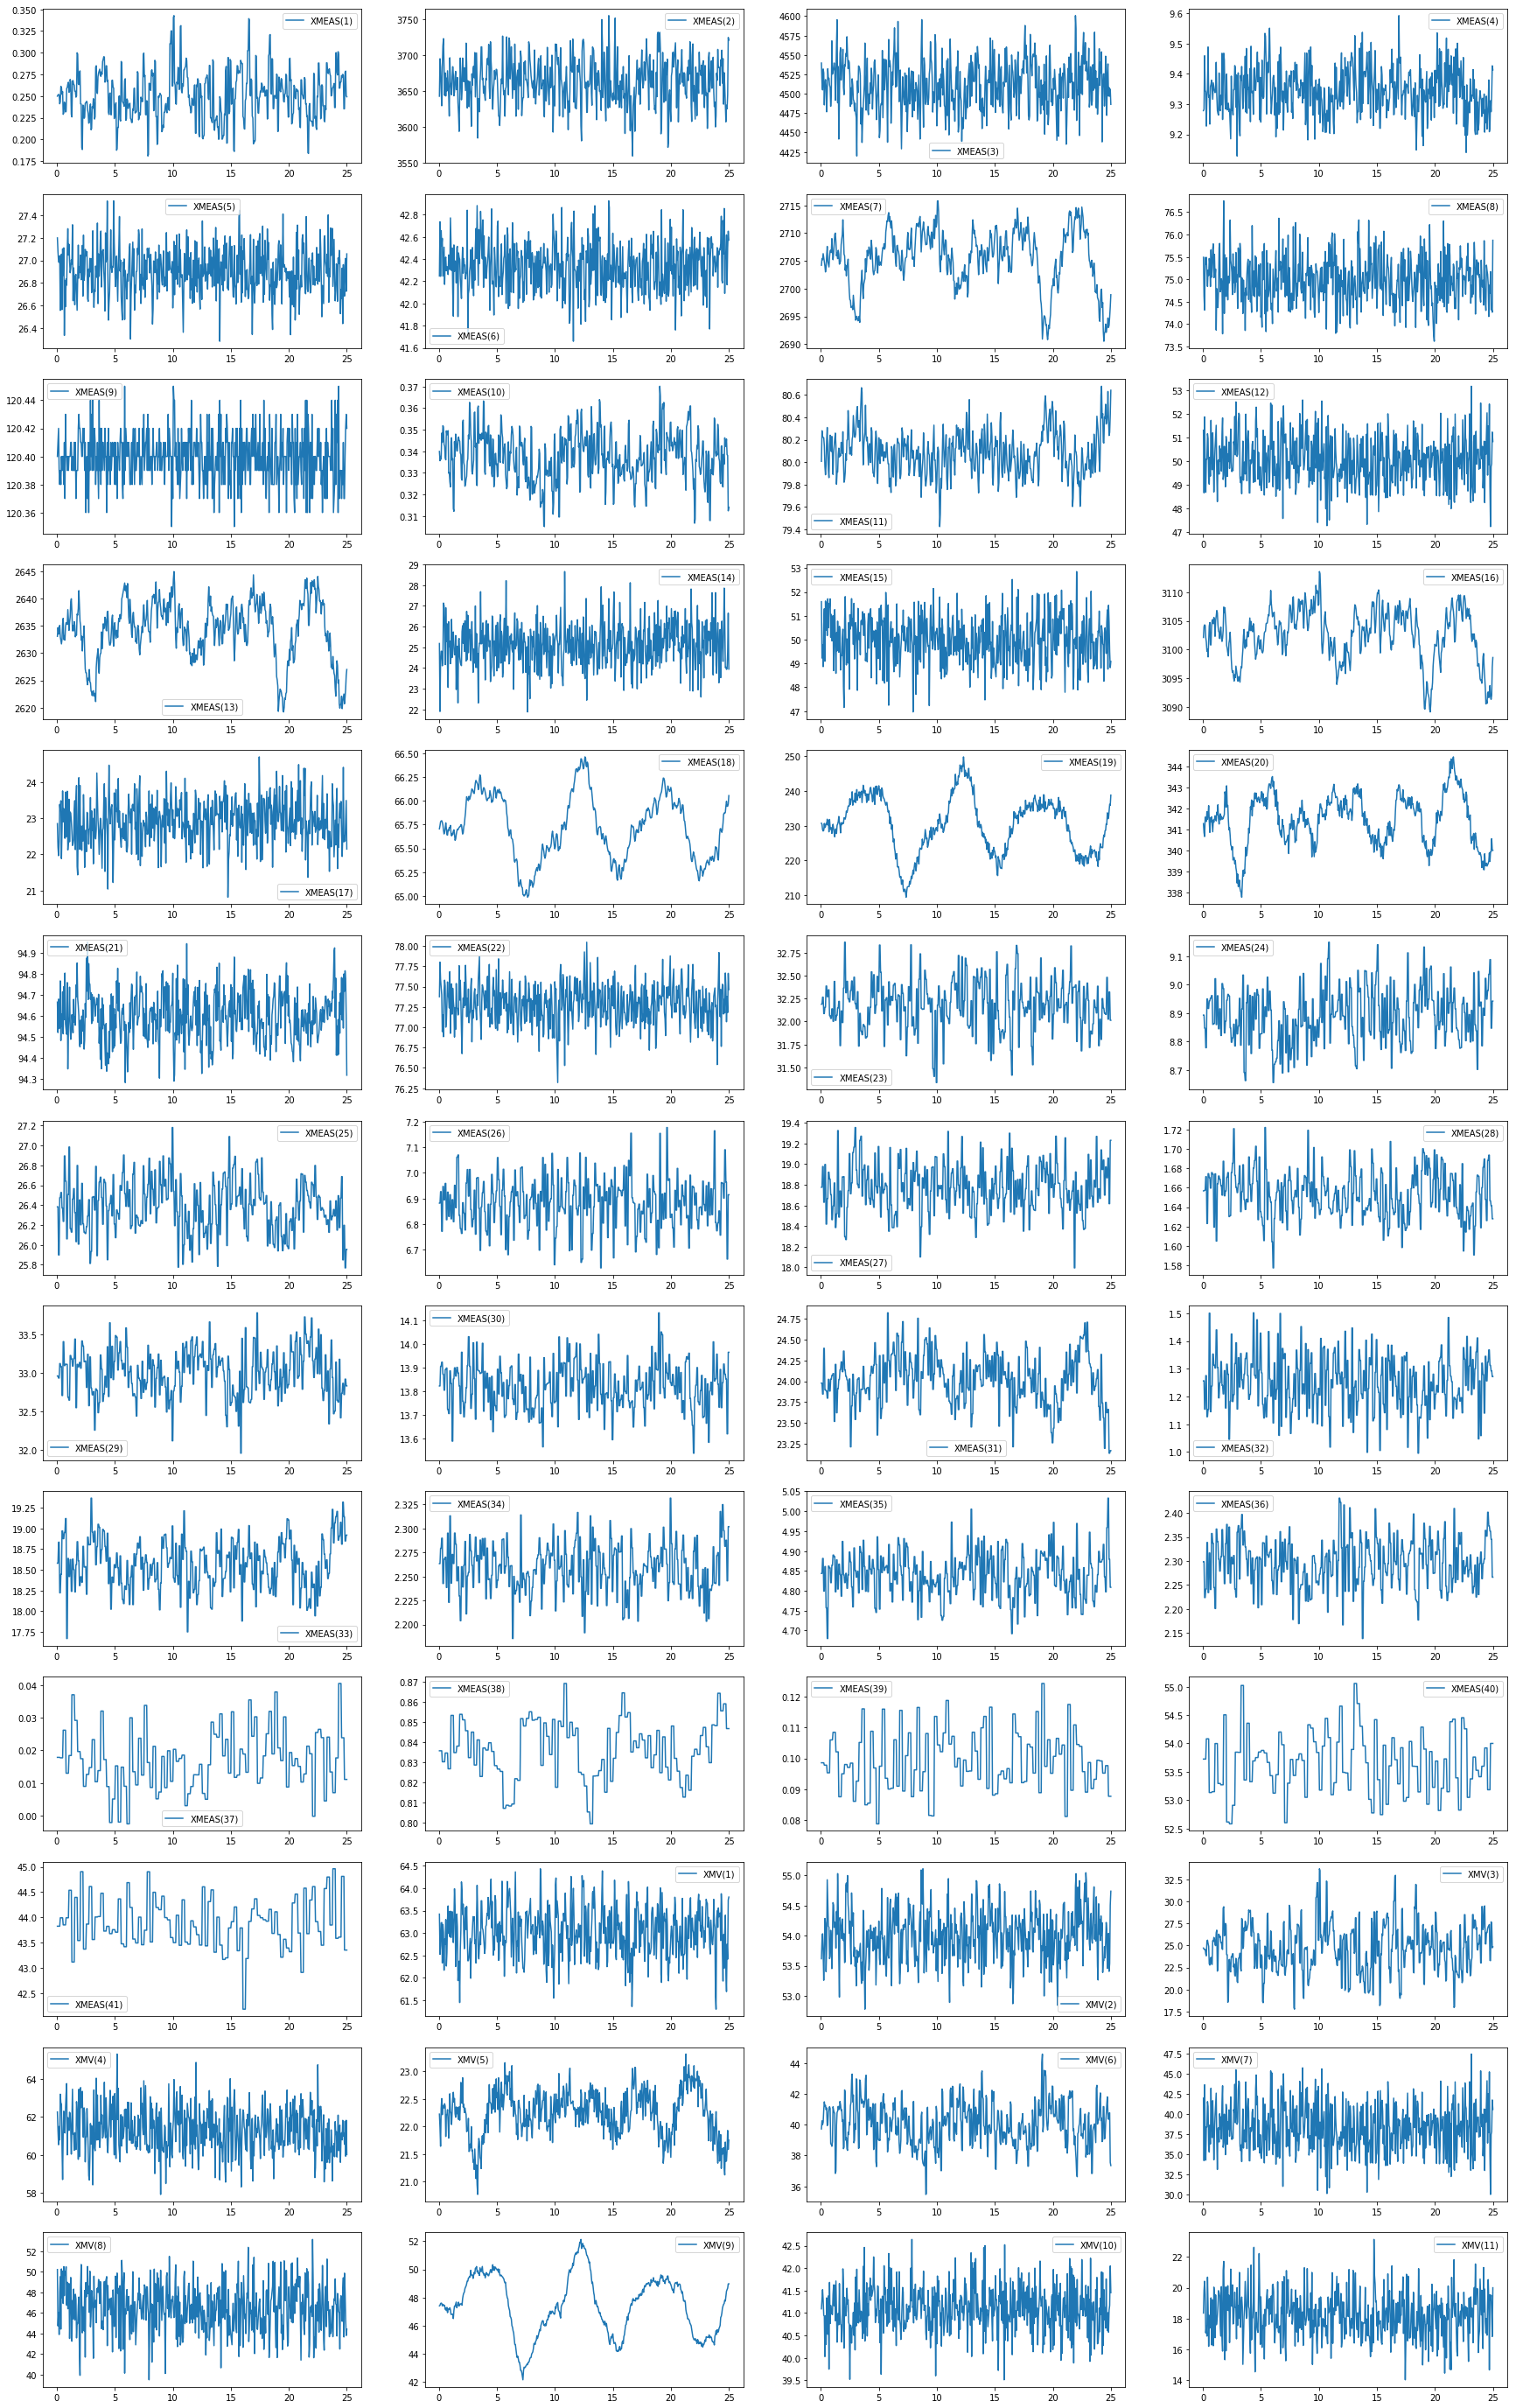

In [9]:
fig, ax = plt.subplots(13,4,figsize=(30,50))

for i in range(dados_treino[0].shape[1]):
    dados_treino[0].iloc[:,i].plot(ax=ax.ravel()[i]) 
    ax.ravel()[i].legend();

Cenário com a falha 4:

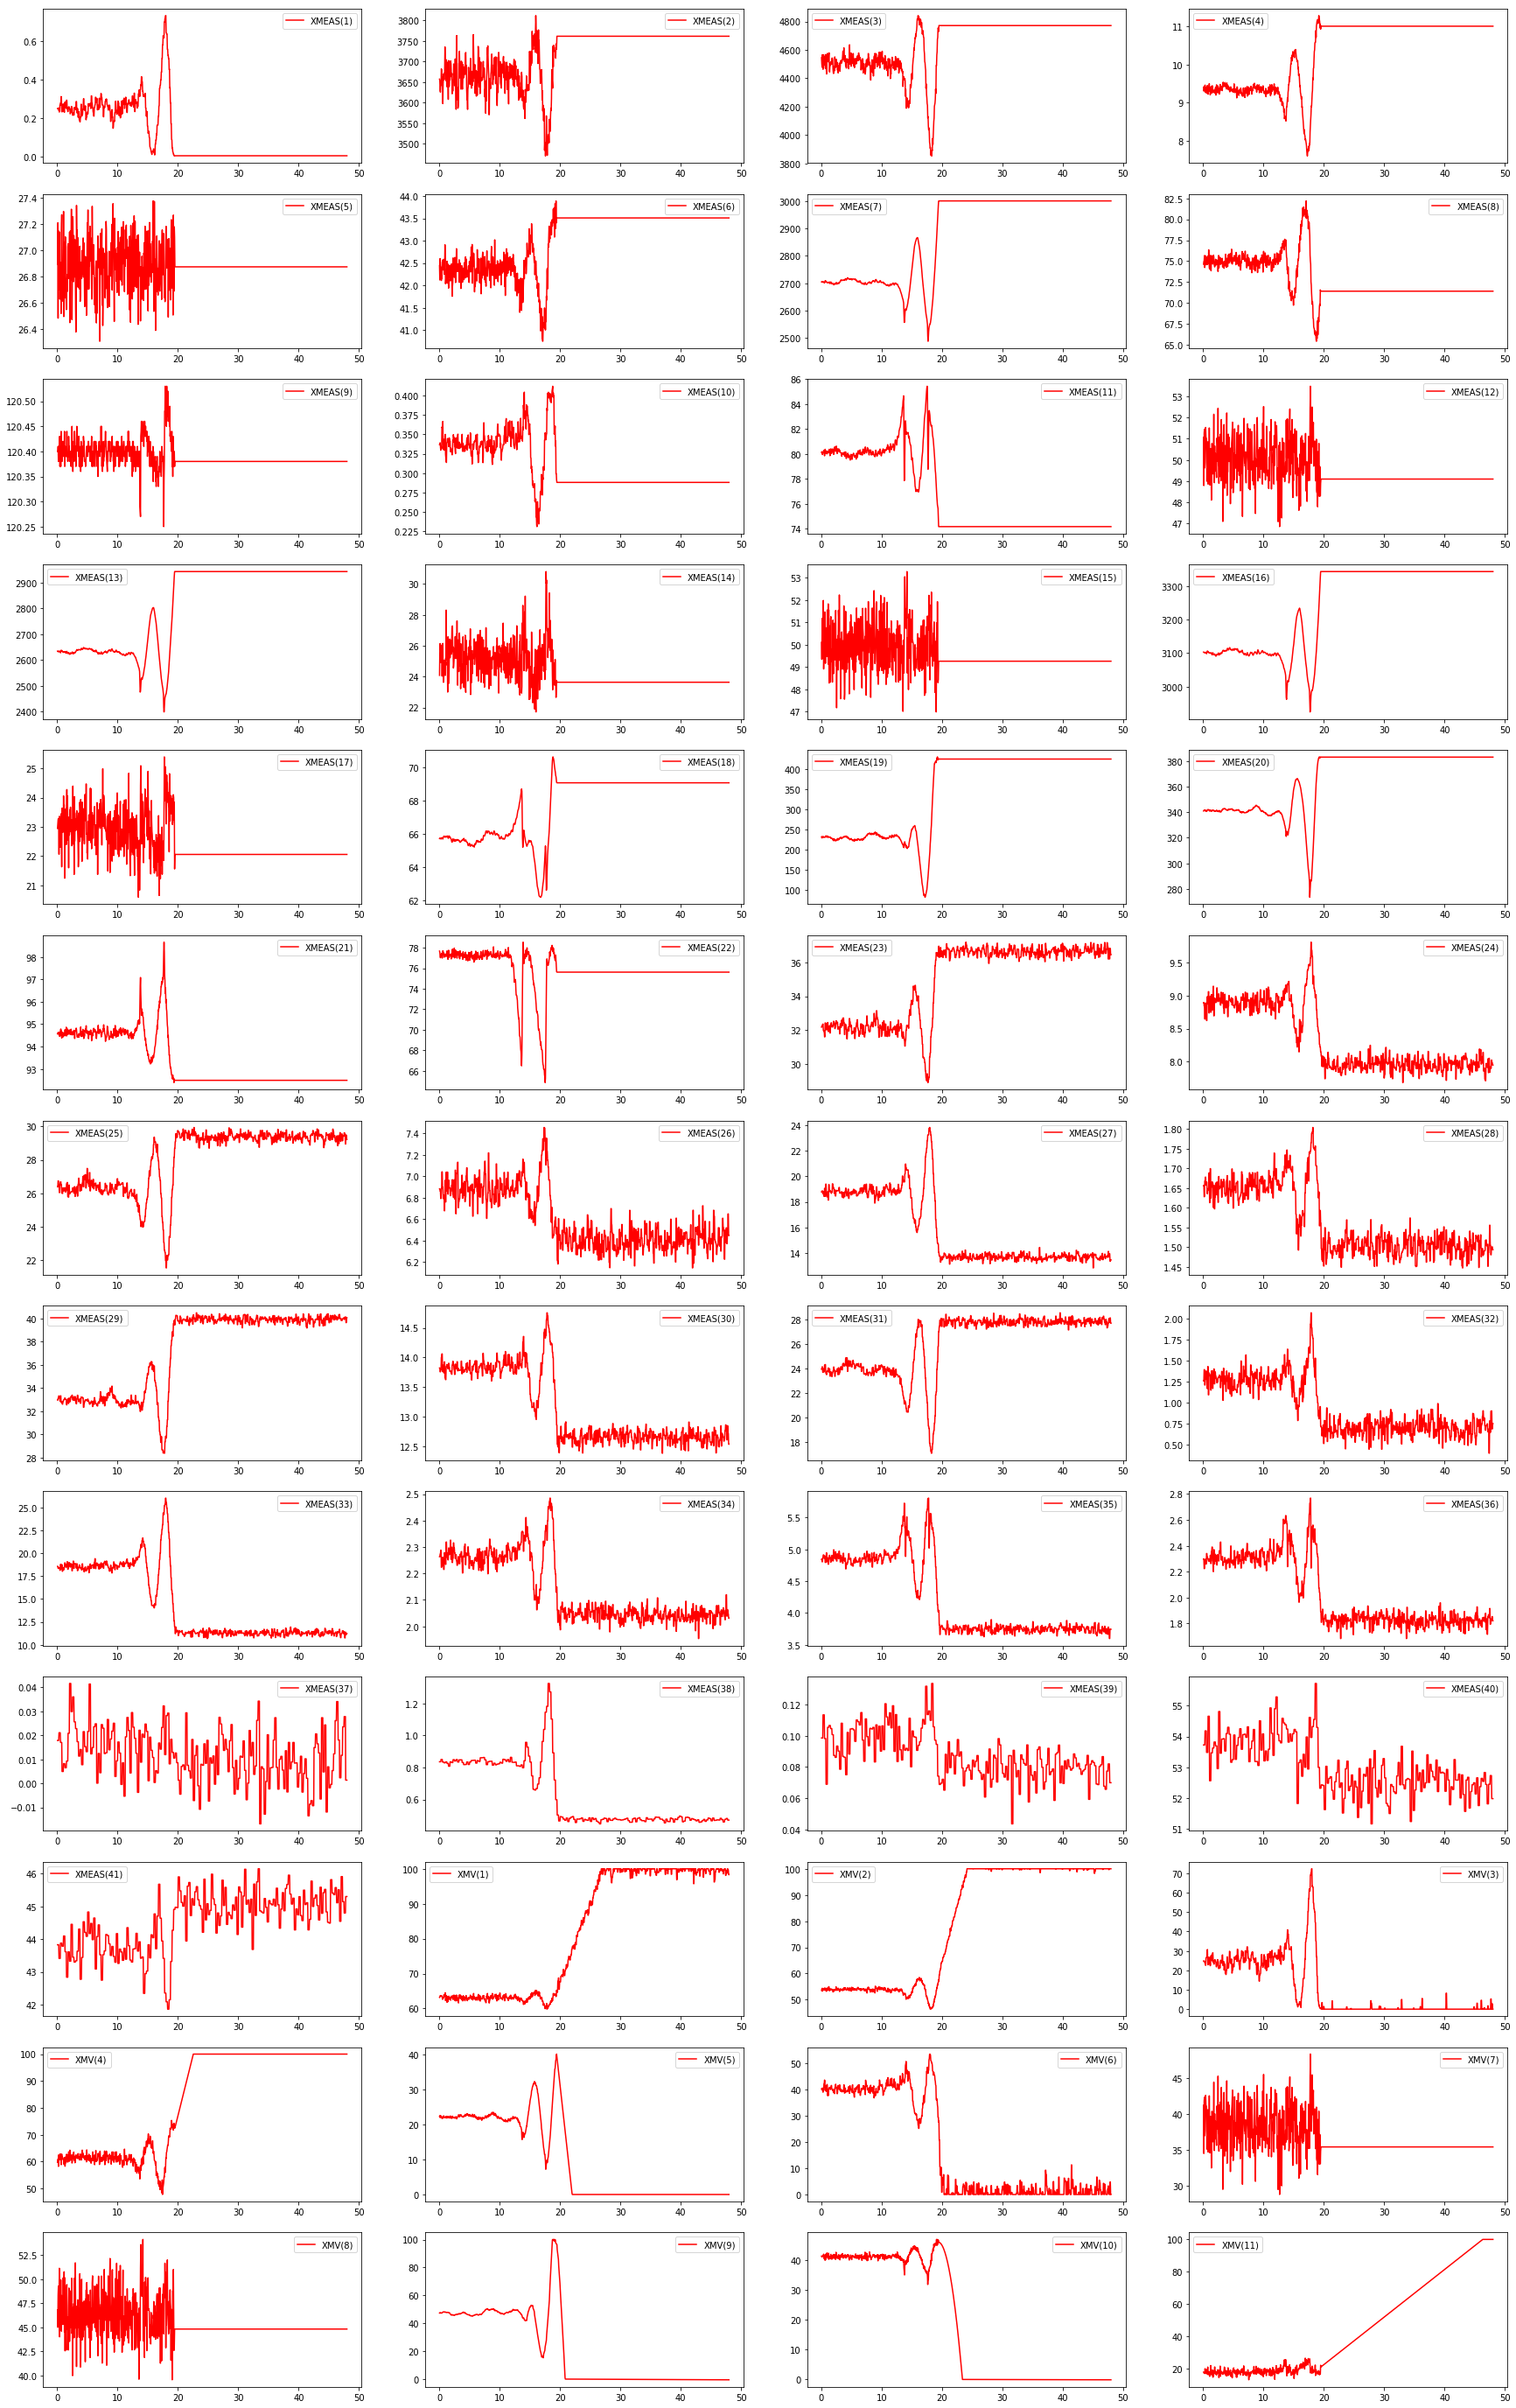

In [10]:
fig, ax = plt.subplots(13,4,figsize=(30,50))

for i in range(dados_teste[4].shape[1]):
    dados_teste[5].iloc[:,i].plot(c='r',ax=ax.ravel()[i]) 
    ax.ravel()[i].legend();

### Aplicando PCA

Treinamento:

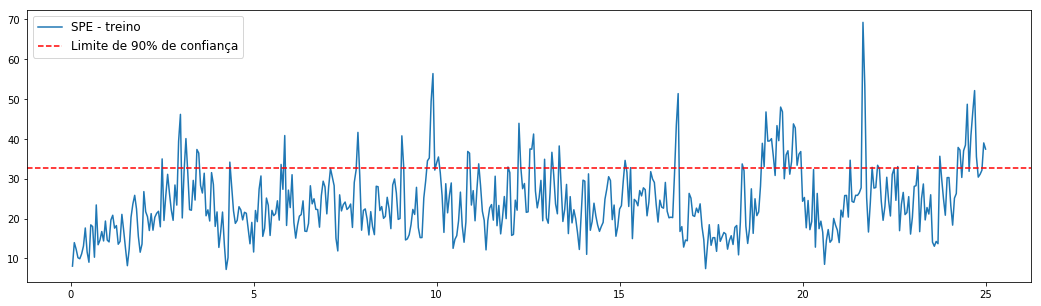

In [11]:
fig,ax=plt.subplots(figsize=(18,5))
V, n, SPE_treino, limSPE, S = treinar_PCA(dados_treino[0],0.9,0.9,ax)

Programando função para plotar a variância cumulativa dos dados:

In [12]:
def plot_var_cum (ax,S):

    pv = S/np.sum(S)
    pva = np.cumsum(S)/sum(S)    
    
    ax.bar(np.arange(len(pv)),pv)
    ax.plot(np.arange(len(pv)),pva)
    ax.set_xlabel('Número de componentes')
    ax.set_ylabel('Variância dos dados')

Utilizando a função:

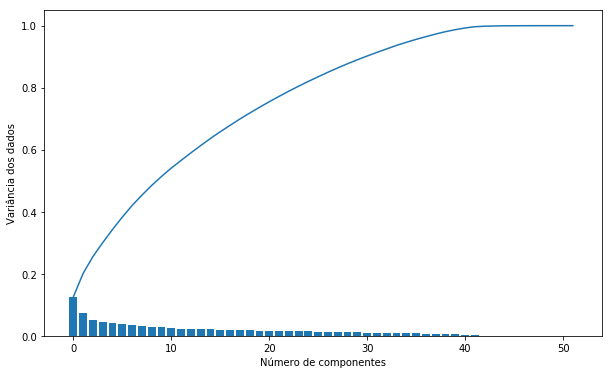

In [13]:
fig, ax = plt.subplots(figsize=(10,6))

plot_var_cum(ax,S)

Analisando no período de teste correspondente a uma das falhas:

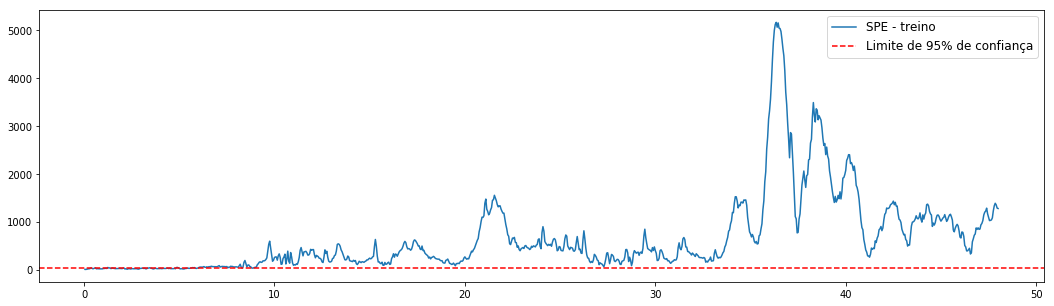

In [14]:
fig,ax=plt.subplots(figsize=(18,5))
testar_PCA(dados_teste[1],dados_treino[0],V,n,limSPE,0.95,ax);

#### *Mão na massa! *

* Aplique o modelo treinado a outras falhas.
* Treine outros modelos PCA (mude variância explicada, limite de confiança, extensão dos dados de treino...). Isso tem algum efeito na detecção das falhas?
* Procure sobre o problema de diagnóstico e identificação de falhas (a bibliografia abaixo é ótima 
para isso). 
* Implemente o diagnóstico de falhas neste notebook utilizando PCA.

### Bibliografia

[Steven Ding - Data-driven Design of Fault Diagnosis and Fault-tolerant Control Systems - Springer](https://www.springer.com/la/book/9781447164098)

[L H Chiang, E L Russell e R D Bratz - Fault Detection and Diagnosis in Industrial Systems - Springer](https://www.springer.com/us/book/9781852333270)